In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import mueller_convolver
import ducc0

In [3]:
def nalm(lmax, mmax):
    return ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)

def make_full_random_alm(lmax, mmax, rng):
    res = rng.uniform(-1., 1., (4, nalm(lmax, mmax))) \
     + 1j*rng.uniform(-1., 1., (4, nalm(lmax, mmax)))
    # make a_lm with m==0 real-valued
    res[:, 0:lmax+1].imag = 0.
    ofs=0
    # components 1 and 2 are spin-2, fix them accordingly
    spin=2
    for s in range(spin):
        res[1:3, ofs:ofs+spin-s] = 0.
        ofs += lmax+1-s
    return res

In [4]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))
nside = 16
lmax = 30
mmax = 2
kmax = 18

In [5]:
fwhm_arcmin = 5
fwhm_rad = np.radians(fwhm_arcmin/60)

# completely random beam
blm = make_full_random_alm(lmax, kmax, rng)
# ... or use a Gauss beam
#blmtmp = blm_gauss_new(fwhm_rad, lmax, True)
#blm *= 0
#blm [0:3, 0:blmtmp.shape[1]] = blmtmp

In [6]:
# completely random sky
slm = make_full_random_alm(lmax, lmax, rng)

In [7]:
pix = hp.ang2pix(nside, np.pi/2, 0) # pixel corresponding to a point on the equator
co_lat = hp.pix2ang(nside, pix)[0]  # co-latitude at the pixel's center
lon = hp.pix2ang(nside, pix)[1]     # longitude at the pixel's center

In [8]:
def fill_alm(alm, lmax, mmax):    
    # returns same as bml, but full alm_size
    alm_size = hp.Alm.getsize(lmax, mmax=mmax)
    alm_full = np.zeros((3,alm_size), dtype = np.complex128)

    idx_start = hp.Alm.getidx(lmax,0,0)
    idx_stop  = hp.Alm.getidx(lmax,lmax,0)
    alm_full[0,idx_start:idx_stop] = alm[0][idx_start:idx_stop]

    idx_start = hp.Alm.getidx(lmax,2,2)
    idx_stop = hp.Alm.getidx(lmax,lmax,2)
    alm_full[1,idx_start:idx_stop] = -alm[1][idx_start:idx_stop]
    alm_full[2,idx_start:idx_stop] = -alm[2][idx_start:idx_stop]
    
    return alm_full

bmap = hp.alm2map(fill_alm(blm,lmax=lmax,mmax=mmax),nside=nside,lmax=lmax,mmax=mmax)
norm = np.sum(bmap[0])

In [9]:
# code by Marta to get beamconv results for user-specified angles
def get_beamconv_values(lmax, kmax, slm, blm, ptg, hwp_angles, mueller,
                        mu_con_hwp, mu_con_spin):
    import beamconv
    import qpoint as qp

    # prepare PO beam file
    blm2 = np.zeros((blm.shape[0], hp.Alm.getsize(lmax=lmax)), dtype=np.complex128)
    blm2[:,:blm.shape[1]] = blm
    blmm, blmp = beamconv.tools.eb2spin(blm2[1],blm2[2])
    blm2[1] = blmm
    blm2[2] = blmp
    np.save("temp_beam.npy", blm2)

    # set up beam and HWP mueller matrix (identity, i.e. no HWP)
    beam = beamconv.Beam(btype='PO', lmax=lmax, mmax=lmax, deconv_q=True, normalize=False, po_file="temp_beam.npy", hwp_mueller=mueller)

    nsamp = ptg.shape[0]

    # from (theta,phi) to (ra,dec) convention
    # also, all angles are converted to degrees
    ra = np.degrees(ptg[:,1])
    dec = 90. - np.degrees(ptg[:,0])
    # Adjustment for difference in convention between qpoint and MuellerConvolver?
    psi = 180. - np.degrees(ptg[:,2])

    # calculate the quaternion
    q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

    def ctime_test(**kwargs):
        return np.zeros(kwargs.pop('end')-kwargs.pop('start'))
    
    def q_bore_test(**kwargs):
        return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

    S = beamconv.ScanStrategy(duration=nsamp, sample_rate=1, external_pointing=True, use_l2_scan=False)
    S.add_to_focal_plane(beam, combine=False)
    S.set_hwp_mod(mode='stepped', freq=1, angles=hwp_angles*180/np.pi)

    # determine nside_spin necessary for good accuracy
    nside_spin = 1
    while nside_spin < 4*lmax:
        nside_spin *= 2

    S.scan_instrument_mpi(slm.copy(), save_tod=True, ctime_func=ctime_test, q_bore_func=q_bore_test,
                      ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin, interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=False, verbose=0, mu_con_hwp=mu_con_hwp, mu_con_spin=mu_con_spin)

    return S.data(S.chunks[0], beam=beam, data_type='tod').copy()

L2 error to original beamconv: 0.7497462710901176
L2 error to beamconv + HWP: 0.7136401220859043
L2 error to beamconv + spin: 0.383777810097028
L2 error to beamconv + HWP + spin: 0.05845322606612044


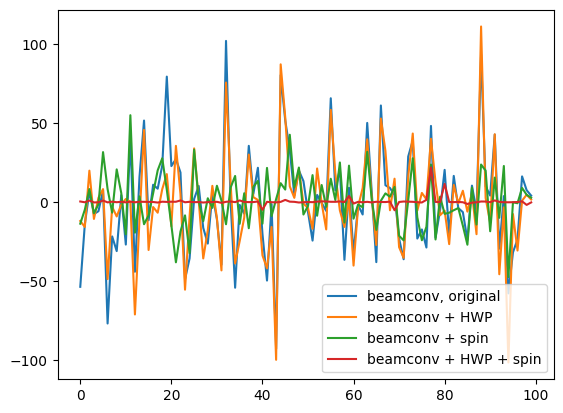

In [10]:
# completely random Mueller matrix
mueller = np.random.uniform(-1,1,size=(4,4))
#mueller[1:3,0]=mueller[1:3,-1] = 0
#mueller[0,2]=mueller[2,0] = 0

nptg=100
# completely random pointings
ptg = np.empty((nptg,3))
ptg[:,0]=np.random.uniform(0,np.pi,size=(nptg,))    # theta
ptg[:,1]=np.random.uniform(0,2*np.pi,size=(nptg,))  # phi
ptg[:,2]=np.random.uniform(0,2*np.pi,size=(nptg,))  # psi
hwp_angles = np.random.uniform(0,2*np.pi,size=(nptg,))  # alpha

# get the signal from beamconv
signal_beamconv_FF = get_beamconv_values(lmax=lmax, kmax=kmax, slm=slm, blm=blm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller, mu_con_hwp=False, mu_con_spin=False)
signal_beamconv_FT = get_beamconv_values(lmax=lmax, kmax=kmax, slm=slm, blm=blm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller, mu_con_hwp=False, mu_con_spin=True)
signal_beamconv_TF = get_beamconv_values(lmax=lmax, kmax=kmax, slm=slm, blm=blm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller, mu_con_hwp=True, mu_con_spin=False)
signal_beamconv_TT = get_beamconv_values(lmax=lmax, kmax=kmax, slm=slm, blm=blm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller, mu_con_hwp=True, mu_con_spin=True)

# Now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=slm,
    blm=blm,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)

# L2 error
print("L2 error to original beamconv:", ducc0.misc.l2error(signal_beamconv_FF, signal_muellerconvolver))
print("L2 error to beamconv + HWP:", ducc0.misc.l2error(signal_beamconv_TF, signal_muellerconvolver))
print("L2 error to beamconv + spin:", ducc0.misc.l2error(signal_beamconv_FT, signal_muellerconvolver))
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv_TT, signal_muellerconvolver))
plt.plot(signal_beamconv_FF-signal_muellerconvolver, label="beamconv, original")
plt.plot(signal_beamconv_TF-signal_muellerconvolver, label="beamconv + HWP")
plt.plot(signal_beamconv_FT-signal_muellerconvolver, label="beamconv + spin")
plt.plot(signal_beamconv_TT-signal_muellerconvolver, label="beamconv + HWP + spin")
#plt.plot(signal_muellerconvolver, label="MuellerConvolver")
plt.legend()
plt.show()